In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
# Import data
df = pd.read_csv('../inputs/airline-passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


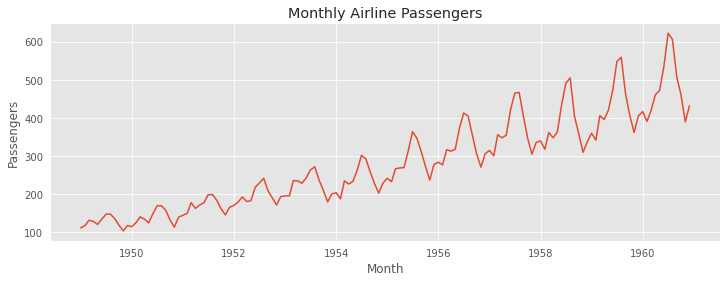

In [10]:
# Plot data
plt.figure(figsize=(12, 4))
plt.plot(df)
plt.title("Monthly Airline Passengers")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.show()

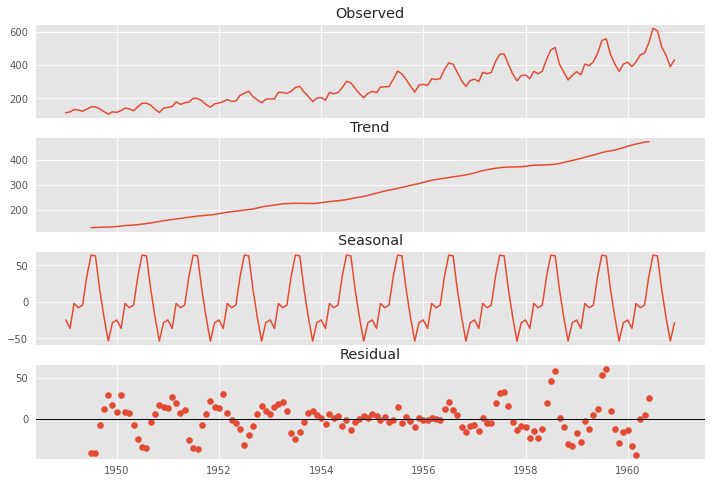

In [27]:
# 移動平均法による分解
# トレンド、季節変動、残差に分解

result = seasonal_decompose(df["Passengers"], model='additive', period=12)

# result.plot() これでも描画できるけど、小さいので、個別に描画する

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 8))

# 原系列
axes[0].set_title("Observed")
axes[0].plot(result.observed)

# トレンド成分
axes[1].set_title("Trend")
axes[1].plot(result.trend)

# 季節成分
axes[2].set_title("Seasonal")
axes[2].plot(result.seasonal)

# 残差成分
axes[3].set_title("Residual")
axes[3].scatter(df.index, result.resid)
axes[3].axhline(y=0, color="black", linewidth=1)

plt.show()

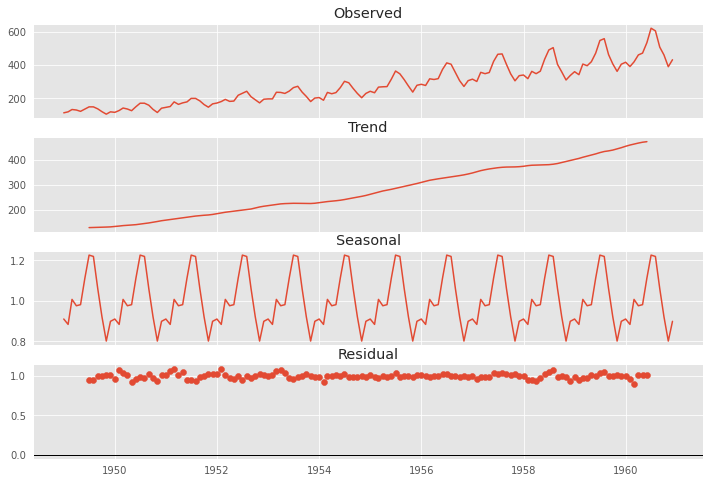

In [28]:
# 移動平均法による分解
# トレンド、季節変動、残差に分解

result = seasonal_decompose(df["Passengers"], model='multiplicative', period=12)

# result.plot() これでも描画できるけど、小さいので、個別に描画する

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 8))

# 原系列
axes[0].set_title("Observed")
axes[0].plot(result.observed)

# トレンド成分
axes[1].set_title("Trend")
axes[1].plot(result.trend)

# 季節成分
axes[2].set_title("Seasonal")
axes[2].plot(result.seasonal)

# 残差成分
axes[3].set_title("Residual")
axes[3].scatter(df.index, result.resid)
axes[3].axhline(y=0, color="black", linewidth=1)

plt.show()

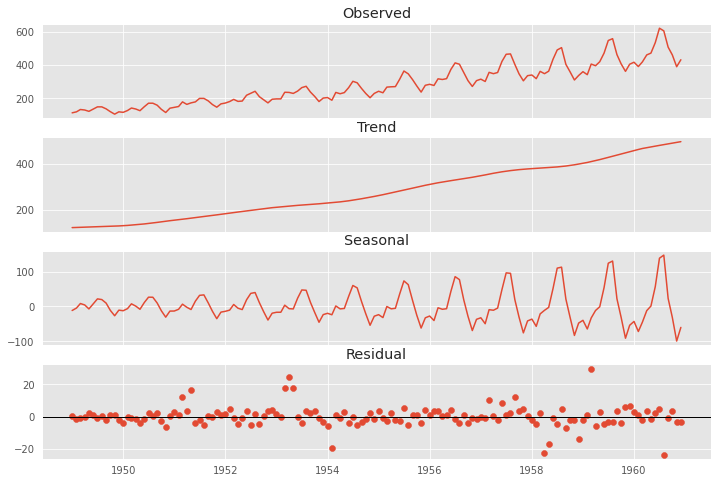

In [31]:
# STL分解
# トレンド、季節変動、残差に分解
stl = STL(df["Passengers"], period=12, robust=True).fit()
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 8))

# 原系列
axes[0].set_title("Observed")
axes[0].plot(stl.observed)

# トレンド成分
axes[1].set_title("Trend")
axes[1].plot(stl.trend)

# 季節成分
axes[2].set_title("Seasonal")
axes[2].plot(stl.seasonal)

# 残差成分
axes[3].set_title("Residual")
axes[3].scatter(df.index, stl.resid)
axes[3].axhline(y=0, color="black", linewidth=1)

plt.show()

## ADF検定

In [34]:
# 原系列で、定常か非定常かを判断する
dftest = adfuller(df["Passengers"])

print("ADF Statistic: %f" % dftest[0])
print("p-value: %f" % dftest[1])
print("Critical Values:")
for key, value in dftest[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


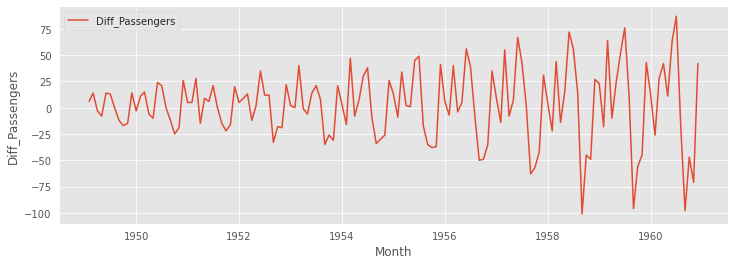

In [37]:
# 差分系列で、定常か非定常かを判断する
# ここで差分系列は1month lagとしてみる
df_diff1 = df.diff(1).dropna()

plt.figure(figsize=(12, 4))
plt.plot(df_diff1, label="Diff_Passengers")
plt.xlabel("Month")
plt.ylabel("Diff_Passengers")
plt.legend()
plt.show()

In [38]:
# P値を確認すると、0.0
dftest = adfuller(df_diff1["Passengers"])

print("ADF Statistic: %f" % dftest[0])
print("p-value: %f" % dftest[1])
print("Critical Values:")
for key, value in dftest[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


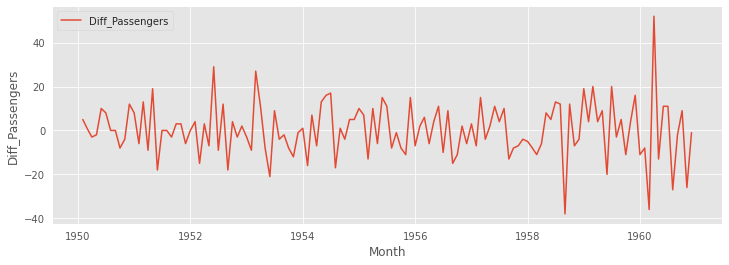

In [40]:
# 差分系列で、定常か非定常かを判断する
# ここで差分系列は12month lagとしてみる
df_diff12 = df_diff1.diff(12).dropna()

plt.figure(figsize=(12, 4))
plt.plot(df_diff12, label="Diff_Passengers")
plt.xlabel("Month")
plt.ylabel("Diff_Passengers")
plt.legend()
plt.show()

In [43]:
# P値を確認すると、0.0
dftest = adfuller(df_diff12["Passengers"])

print("ADF Statistic: %f" % dftest[0])
print(f"p-value: {dftest[1]}")
print("Critical Values:")
for key, value in dftest[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -15.595618
p-value: 1.856511600123444e-28
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


## 自己相関、偏自己相関

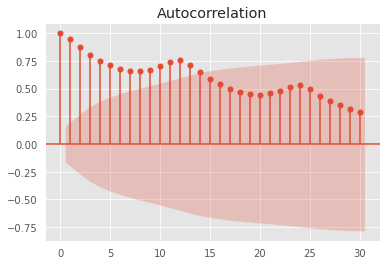

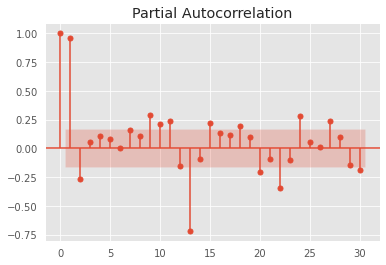

In [44]:
# 原系列
acf = plot_acf(df["Passengers"], lags=30)
pacf = plot_pacf(df["Passengers"], lags=30)

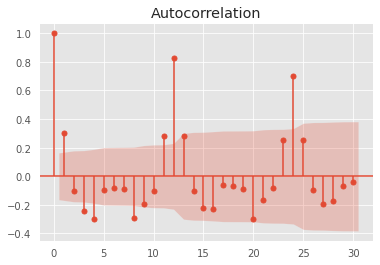

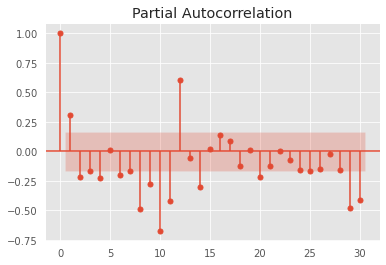

In [45]:
acf = plot_acf(df_diff1["Passengers"], lags=30)
pacf = plot_pacf(df_diff1["Passengers"], lags=30)

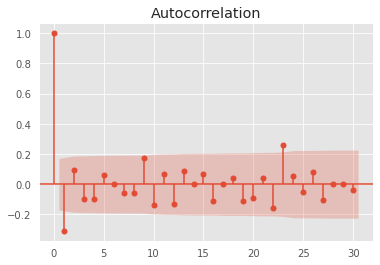

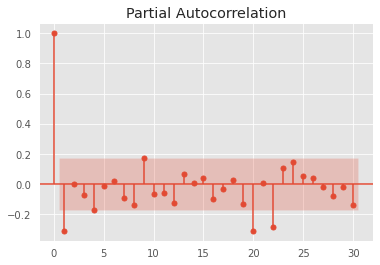

In [46]:
acf = plot_acf(df_diff12["Passengers"], lags=30)
pacf = plot_pacf(df_diff12["Passengers"], lags=30)

## ARIMAモデルの構築

季節性、トレンドがはっきりしているものであればある程度で精度でる

In [53]:
from pmdarima import auto_arima

# 時系列用のtrain_test_splitの模様
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import datetime

In [54]:
train_df, test_df = train_test_split(df, test_size=12)

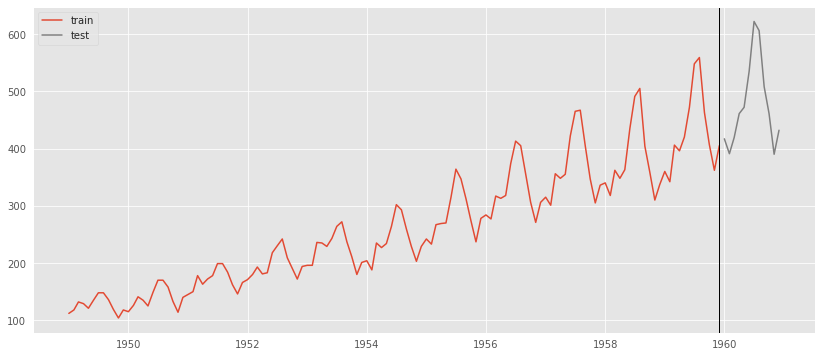

In [57]:
# train, testを描画
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train_df.index, train_df["Passengers"], label="train")
ax.plot(test_df.index, test_df["Passengers"], label="test", color="gray")

ax.axvline(x=train_df.index[-1], color="black", linewidth=1)
plt.legend()
plt.show()

In [59]:
# モデルの実装
arima_model = auto_arima(
    train_df,
    seasonal=True,
    m=12,
)
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Sun, 02 Jul 2023   AIC                            905.686
Time:                                    12:10:40   BIC                            919.623
Sample:                                         0   HQIC                           911.346
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095   

In [60]:
# 推論
train_pred = arima_model.predict_in_sample()
test_pred = arima_model.predict(n_periods=12)

In [61]:
# 評価
print(f"RMSE: {np.sqrt(mean_squared_error(test_df['Passengers'], test_pred))}")
print(f"MAE: {mean_absolute_error(test_df['Passengers'], test_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(test_df['Passengers'], test_pred)}")

RMSE: 18.536468761263798
MAE: 14.898208278386472
MAPE: 0.03097561526658857


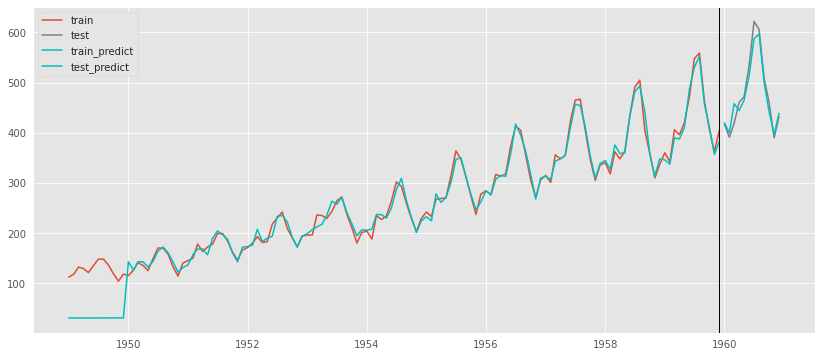

In [62]:
# 推論結果を描画
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train_df.index, train_df["Passengers"], label="train")
ax.plot(test_df.index, test_df["Passengers"], label="test", color="gray")

ax.plot(train_df.index, train_pred, label="train_predict", color="c")
ax.plot(test_df.index, test_pred, label="test_predict", color="c")

ax.axvline(x=train_df.index[-1], color="black", linewidth=1)

plt.legend()
plt.show()

## ホルト・ウィンタース法

最初の時系列部分でも精度が出ている点がARIMAとの違い

In [1]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [64]:
# モデルの実装
hw_model = ExponentialSmoothing(
    train_df,
    trend="additive", # トレンド成分：加法モデル
    seasonal="additive", # 季節成分：加法モデル
    seasonal_periods=12,
)
hw_model_fit = hw_model.fit()

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [65]:
# 推論
# 学習データの予測
train_pred = hw_model_fit.fittedvalues

# テストデータの予測
test_pred = hw_model_fit.forecast(12)

In [66]:
# 評価
print(f"RMSE: {np.sqrt(mean_squared_error(test_df['Passengers'], test_pred))}")
print(f"MAE: {mean_absolute_error(test_df['Passengers'], test_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(test_df['Passengers'], test_pred)}")

RMSE: 15.570830426797155
MAE: 10.455563520953206
MAPE: 0.0231719808956163


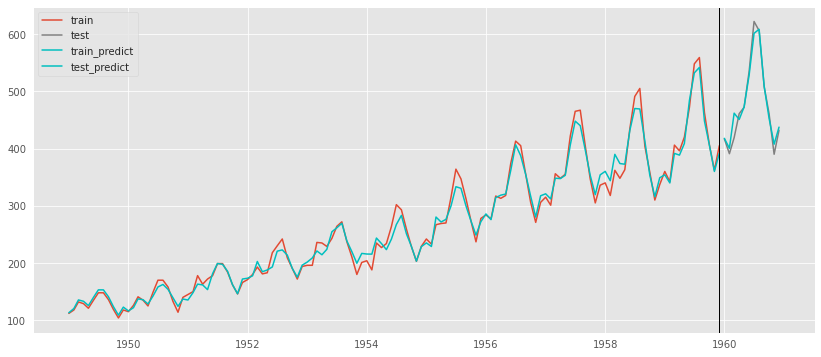

In [67]:
# 推論結果を描画
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train_df.index, train_df["Passengers"], label="train")
ax.plot(test_df.index, test_df["Passengers"], label="test", color="gray")

ax.plot(train_df.index, train_pred, label="train_predict", color="c")
ax.plot(test_df.index, test_pred, label="test_predict", color="c")

ax.axvline(x=train_df.index[-1], color="black", linewidth=1)

plt.legend()
plt.show()

## prophetでの予測

In [69]:
from prophet import Prophet

In [72]:
prophet_data = pd.read_csv("../inputs/airline-passengers.csv")
prophet_data.columns = ["ds", "y"]

# データの分割
train_df, test_df = train_test_split(prophet_data, test_size=12)

In [73]:
m = Prophet()
m.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [74]:
# 予測
df_pred_test = m.make_future_dataframe(periods=12, freq="M")
df_pred = m.predict(df_pred_test)
prophet_data["predicted"] = df_pred["yhat"]

train_pred = prophet_data.iloc[:-len(test_df)]["predicted"]
test_pred = prophet_data.iloc[-len(test_df):]["predicted"]

In [76]:
# 評価
print(f"RMSE: {np.sqrt(mean_squared_error(test_df['y'], test_pred))}")
print(f"MAE: {mean_absolute_error(test_df['y'], test_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(test_df['y'], test_pred)}")

RMSE: 41.49581952307306
MAE: 33.98202055400839
MAPE: 0.06782285132124276


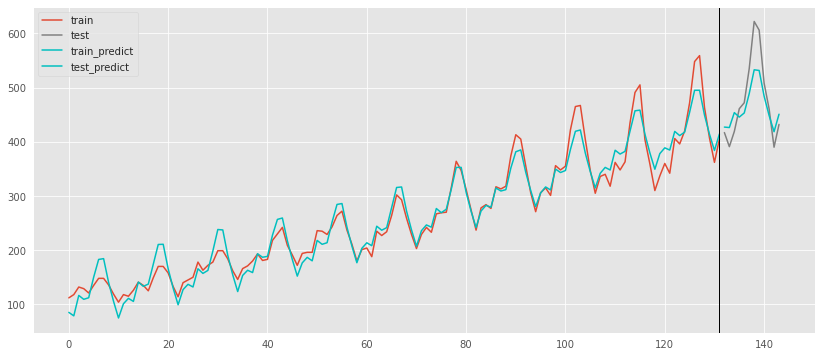

In [77]:
# 推論結果を描画
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train_df.index, train_df["y"], label="train")
ax.plot(test_df.index, test_df["y"], label="test", color="gray")

ax.plot(train_df.index, train_pred, label="train_predict", color="c")
ax.plot(test_df.index, test_pred, label="test_predict", color="c")

ax.axvline(x=train_df.index[-1], color="black", linewidth=1)

plt.legend()
plt.show()

In [80]:
# パラメータの探索
import optuna
from sklearn.model_selection import TimeSeriesSplit

# データの読み込み
prophet_data = pd.read_csv("../inputs/airline-passengers.csv")
prophet_data.columns = ["ds", "y"]

# データの分割
train_df, test_df = train_test_split(prophet_data, test_size=12)

def objective(trial):
    params = {
        "changepoint_prior_scale": trial.suggest_float("changepoint_prior_scale", 0.001, 0.5),
        "seasonality_prior_scale": trial.suggest_float("seasonality_prior_scale", 0.01, 10.0),
        "seasonality_mode": trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]),
        "changepoint_range": trial.suggest_float("changepoint_range", 0.8, 0.95, step=0.001),
        "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
    }

    tss = TimeSeriesSplit(test_size=12)
    cv_mse = []
    # 交差検証
    for fold, (train_idx, valid_idx) in enumerate(tss.split(train_df)):
        train_data = train_df.iloc[train_idx]
        valid_data = train_df.iloc[valid_idx]

        m = Prophet(**params)

        m.fit(train_data)
        df_future = m.make_future_dataframe(periods=len(valid_data), freq="M")
        df_pred = m.predict(df_future)
        preds = df_pred.tail(len(valid_data))

        cv_mse.append(mean_squared_error(valid_data["y"], preds["yhat"]))

    return np.mean(cv_mse)

optuna.logging.disable_default_handler()

study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100, n_jobs=-1)

print(study.best_params)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True 

{'changepoint_prior_scale': 0.02472145206570222, 'seasonality_prior_scale': 7.856799974929159, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8340000000000001, 'n_changepoints': 30}


In [81]:
# 最適化したパラメータでの予測
m = Prophet(**study.best_params)
m.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [82]:
# 予測
df_pred_test = m.make_future_dataframe(periods=12, freq="M")
df_pred = m.predict(df_pred_test)
prophet_data["predicted"] = df_pred["yhat"]

train_pred = prophet_data.iloc[:-len(test_df)]["predicted"]
test_pred = prophet_data.iloc[-len(test_df):]["predicted"]

In [83]:
# 評価
print(f"RMSE: {np.sqrt(mean_squared_error(test_df['y'], test_pred))}")
print(f"MAE: {mean_absolute_error(test_df['y'], test_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(test_df['y'], test_pred)}")

RMSE: 19.81295116113201
MAE: 17.693256187622254
MAPE: 0.03666814414044983


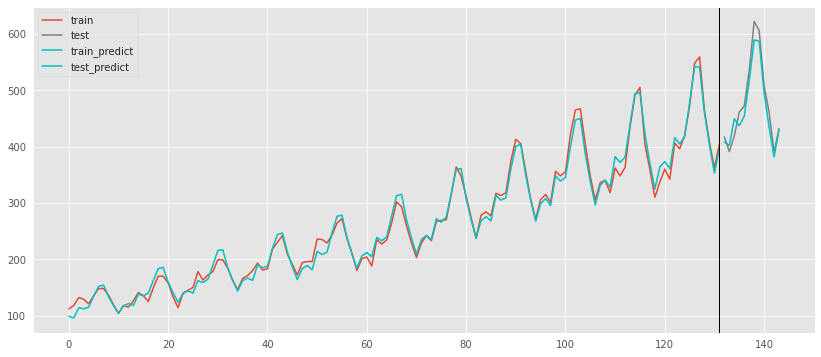

In [84]:
# 推論結果を描画
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train_df.index, train_df["y"], label="train")
ax.plot(test_df.index, test_df["y"], label="test", color="gray")

ax.plot(train_df.index, train_pred, label="train_predict", color="c")
ax.plot(test_df.index, test_pred, label="test_predict", color="c")

ax.axvline(x=train_df.index[-1], color="black", linewidth=1)

plt.legend()
plt.show()